# Machine learning- ERM and Bayesian

##### Keywords: supervised learning, generative model, discriminative models, machine learning, empirical risk minimization

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$

First some often used routines.

In [8]:
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

In [3]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 


## The different kinds of learning

![learning](https://dl.dropboxusercontent.com/u/75194/learning.png)

### ERM 

The Empirical Risk Maximization (ERM) approach corresponds to estimating the true distribution by the empirical distribution. In this case the Risk R is simply the average of the losses at the individual training points:

$$ R(g) = \frac{1}{N} \sum_i l(g(x_i), y_i) .$$

(Diagrams like the one below are chopped out from http://web4.cs.ucl.ac.uk/staff/D.Barber/textbook/240415.pdf . Reading Chapter 13 as a survey of machine learning is especially recommended)

![ERM learning](https://dl.dropboxusercontent.com/u/75194/erm.png)

The optimal decision in the training set is obviously the value of $y$ at the training point, but we are left with undefined action $g$ outside the training set. We thus pick some parametric model $g(x;\theta)$. Now we can minimize the empirical risk with respect to $\theta$ to get $\theta_{opt}$ and use this to make predictions/actions using $g$. Because such an approach can lead to overfitting as we have seen before, we typically add a regularization term with co-efficient $\lambda$ whose value is found by validation.

Notice that in all of this any talk of density estimation has gone away, and we are just minimizine the averaged loss over the training set plus regularization, the so-called Structural Risk maximization approach of Vapnik, whose motto is (paraphrased): **Never solve a more difficult problem (density estimation) while solving a difficut one (learning)**. The function $g$ is then sometimes called a discriminant function, and we are choosing it based on *minimal risk, which is the quantity we are ultimately interested in*. 

![](http://yann.lecun.com/ex/images/allyourbayes.jpg)

But there are drawbacks. It seems crazy to assume that the empirical distribution is a good distribution, especially for small data. A more reasonable assumption for the distribution could take into account likely x,y that could arise. If the loss changes, as it might over time, say in a financial application, then we would need to retrain $g$. There is no way to associate a confidence in this framework, as it wont give you probabilities. 

### Bayes

![Bayesian learning](images/bayesrisk.png)

The alternative is to first do density estimation. We estimate $p(x,y)$ (or $p(x,c)$) from the training data. (Note that this can be thought of as ERM on risk $-log(p)$). (In the "Learning Models" lab we said that another way to think about a noisy $y$ is to imagine that our data $\dat$ was generated from  a joint probability distribution $p(x,y)$ rather than some well given function$y=f(x)$.)

The joint distribution can be constructed in two ways: generative or discriminative. The **discriminative** approach gives us:

$$p(x,c) = p(c|x)p(x)$$

whereas the **generative approach** gives us

$$p(x,c) = p(x|c) p(c)$$

and then bayes theorem can be used to obtain p(c|x).

The generative approach corresponds to picking one of the classes with probability p(c) and then getting the density of the features for that class. The discriminative approach models the domain boundary instead. While the data may be distributed in a complex way, the boundary may be easier to model. On the other hand prior information for assymetric situations, conditional independence and other such strategies can only be done in generative models.

![Bayesian learning](images/genvsdiscrim.png)

In either case we can get the joint distribution. In the discriminative case that leads us to density estimation for $p(x)$. Often we have no use for it so we wont do it, as in logistic regression. But do remember that if we want our classifier to have good results we should be using it on test sets which reflect the proper sampling $p(x)$. And if we dont characterize it we might be better of using a generative model as it is easier to adjust for class priors.

The Bayesian decision approach is a clean one, in which first one models the **environment**, independent of the subsequent decision process. If $p(y,x|\theta)$ is the "true" model of the world, this is optimal. But if this **environment model** is poor, the action $g$ could be higly inaccurate since the environment is divorced from prediction. In practice one often includes regularization terms in the environment model to reduce the complexity of the distribution and bring it more in line with decision based hyperparameters, set by validation on an empirical loss. See the cs109 (2013) Naives bayes homework for a good example.

By the way, the ERM method is the only **frequentist** method which has a well defined risk. The reason for this is that it dosent depend on both a sample-estimate of the true $\theta$.

In [4]:
df=pd.read_csv("data/01_heights_weights_genders.csv")
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


### Discriminative Model

In [9]:
from sklearn.linear_model import LogisticRegression
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), {"C": [0.01, 0.1, 1, 10, 100]}, df, ['Weight', 'Height'], 'Gender','Male')

BEST PARAMS {'C': 0.1}
Accuracy on training data: 0.92
Accuracy on test data:     0.92


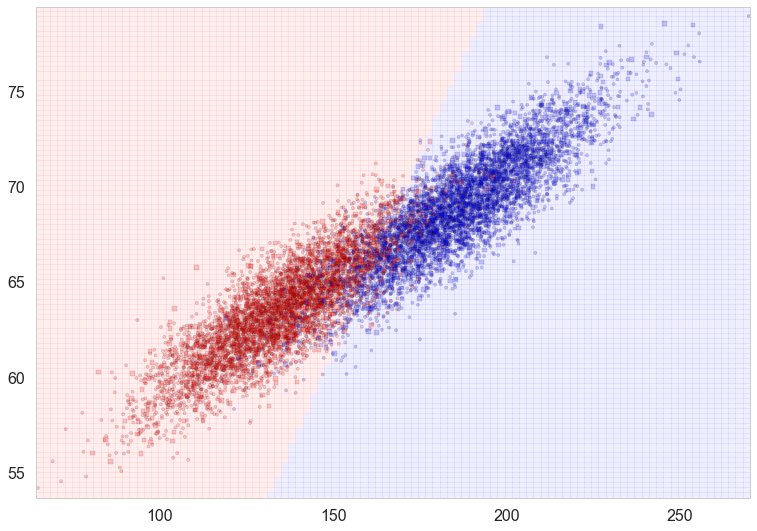

In [10]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, alpha=0.2);

 Let us plot the probabilities obtained from `predict_proba`, overlayed on the samples with their true labels:

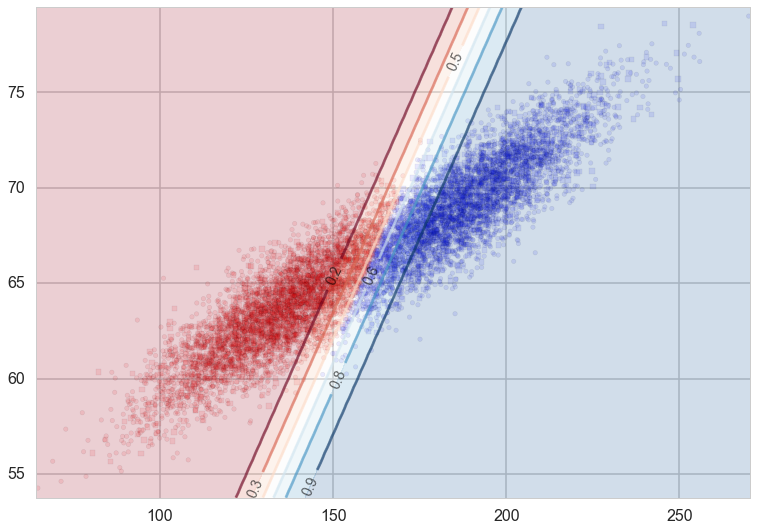

In [11]:
plt.figure()
ax=plt.gca()
points_plot_prob(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, psize=20, alpha=0.1);

Notice that lines of equal probability, as might be expected are stright lines. What the classifier does is very intuitive: if the probability is greater than 0.5, it classifies the sample as type '1' (male), otherwise it classifies the sample to be class '0'. Thus in the diagram above, where we have plotted predicted values rather than actual labels of samples, there is a clear demarcation at the 0.5 probability line.

This notion of trying to obtain the line or boundary of demarcation is what makes the **discriminative** classifier. The algorithm tries to find a decision boundary that separates the males from the females. To classify a new sample as male or female, it checks on which side of the decision boundary the sample falls, and makes a prediction. In other words we are asking, given $\v{x}$, what is the probability of a given $y$, or, what is the likelihood $P(y|\v{x},\v{w})$?

### Generative Classifier

This involves finding $P(\v{x} | y)$, the class conditional probability. Consider that heights and weights of males and females might be expected to be distributed using a bell curve. You might have heard of the reasons for this: so many things go into these heights/weights that the net effect is for them to be distributed as a bell curve, according to the central limit theorem. So why not use this additional information and model the heights and weights of males and females separately as 2-dimensional bell curves or **Normal Distributions**. In other words:

$$p(height, weight | male ) = Bell Curve$$

centered at the mean height, weight for males, and a similar equation holds for females. This is exactly what the linear discriminant analysis classifier does.  Lets run it, only on tne training set. What we are doing is fitting the male and female sections of the training set separately, getting two 2-D bell curves, and then inverting as above to decide how to classify new samples from the testing set. (We dont cross-validate here as we are currently not fitting any hyperparameters).

In [12]:
from sklearn.lda import LDA
clflda = LDA(solver="svd", store_covariance=True)
clflda.fit(Xtrain_l, ytrain_l)

//anaconda/envs/py35/lib/python3.5/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=True, tol=0.0001)

In [13]:
#from REF
from scipy import linalg

def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, color=color, lw=3, fill=False)
    ell.set_clip_box(splot.bbox)
    ell1 = mpl.patches.Ellipse(mean, 1 * v[0] ** 0.5, 1 * v[1] ** 0.5,
                              180 + angle, color=color, lw=3, fill=False)
    ell1.set_clip_box(splot.bbox)
    ell3 = mpl.patches.Ellipse(mean, 3 * v[0] ** 0.5, 3 * v[1] ** 0.5,
                              180 + angle, color=color, lw=3, fill=False)
    ell3.set_clip_box(splot.bbox)
    #ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.add_artist(ell1)
    splot.add_artist(ell3)


    #splot.set_xticks(())
    #splot.set_yticks(())
def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')
#plt.bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0, mux=0.0, muy=0.0, sigmaxy=0.0)¶

We plot ellipses for equal probability contours of the two individual $P(\v{x}|y)$, the $P(height, weight | male)$ and the $P(height, weight | female)$. We also plot the discriminant line created by inverting these probabilities using Bayes theorem: we once again classify a sample as male if $P(male | height, weight \gt 0.5$ (which will ensure that $P(female | height, weight) < 0.5$ since both must add to 1).

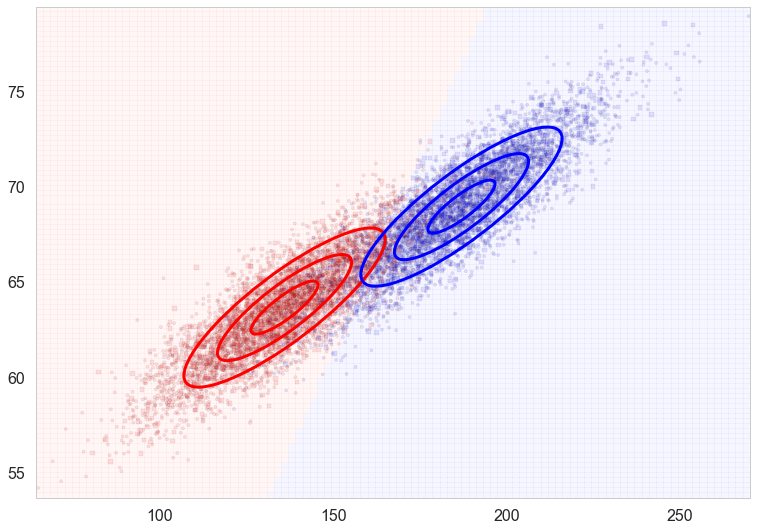

In [14]:
plt.figure()
ax=plt.gca()
spl,_,_=points_plot(ax,Xtrain_l, Xtest_l, ytrain_l, ytest_l, clflda)
plot_lda_cov(clflda, spl)


Whats happenning here? We have estimated $P(\v{x} | y, \theta_y)$ where we use $\theta_y$ to designate the parameters of the fit (the parameters of the female and male bell curves); the subscript indicates we are fitting a separate parameter set for each class.

We can then use Bayes theorem (which we briefly talked about in chapter REF) to invert to find $P(y | \v{x})$, the probability we really want thus:

$$P(y | \v{x}) = \frac{P(\v{x} | y, \theta_{y}) P(y)}{P(x)} = \frac{P(\v{x} | y) P(y)}{\sum_{y} P(\v{x} | y, \theta_{y})P(y)} .$$

Notice from the first term above that the denominator $P(\v{x})$ does not involve the parameters, it is simply the input distribution of the features. As such, it is not needed in the prediction process.

For our special case of two classes:

$$P(y = c_1 | \v{x}) = \frac{P(\v{x} | y = c_1, \theta_1) P(y=c_1)}{P(\v{x} | y = c_1, \theta_1) P(y=c_1) + P(\v{x} | y = c_0, \theta_0) P(y=c_0)}$$

In other words, we first look at males, and build a model of the features for the males. Then we do a similar thing for females. To classify a new sample, we match it against the model for males, and then the model for females, and user Bayes theorem to see if the new sample more likely looks like the males rather than the females from the training set. 

Another way to think about this is that you can **generate** or simulate a new male or female sample from this model $P(\v{x} | y, \theta_y)$ of males or females respectively. The idea is that you first toss a (possibly biased) coin which depends on $P(y=c_1)$, the "prior" probability of a sample being male or female. Once that coin has landed male or female ("once the draw has been made"), generate a sample in feature space using $P(\v{x}|what landed)$. For example, if the coin landed female, now draw a height and weight according to $$P(height, wieght | female )$$. Thus there is a *story* for how to generate samples in such models. If this story is the "correct" or "nearly correct" one, this is likely to be a very good model, and furthermore, we can draw new training sets to check variance and other measures of our classifier's accuracy.

You can see three important aspects of this method from these formulae already. First, you model the classes separately. Secondly, the formula involves $P(y)$, the prior probability of the sample being in the class. This is usually just taken to be the fraction of a particular class in the training sample. 

Being able to fold this information is key when the classes are very imbalanced in the training data set. For example, consider again the case of trying to predict if a customer will "churn". Typically churn rates are low, of the order of 2-3%.In this case having the prior probabilities of churning and not-churning, and modelling thse groups separately in a generative classifier is very useful: it might be hard for a discriminative classifier to draw a boundary between many many samples on one side and just a few on the other: one might rightly expect this boundary to be a bit fragile.

The third thing is probably obvious and a bit uncomfortable to you: we are being asked to provide much more information: the priors, the individual class models, all of that. It would seem that to get the same kind of classification we are being asked to provide more information.

This is true, but it is not a bad thing when the assumptions that go into individual models are well founded, such as in the case of our male and female heights and weights here. 

We can also plot the output of `predict_proba` and we see something interesting: we get back exactly the same probability lines that we got using logistic regression. Indeed, LDA is the generative conterpart of Logistic regression. It is possible to prove this but we shall not do so here.

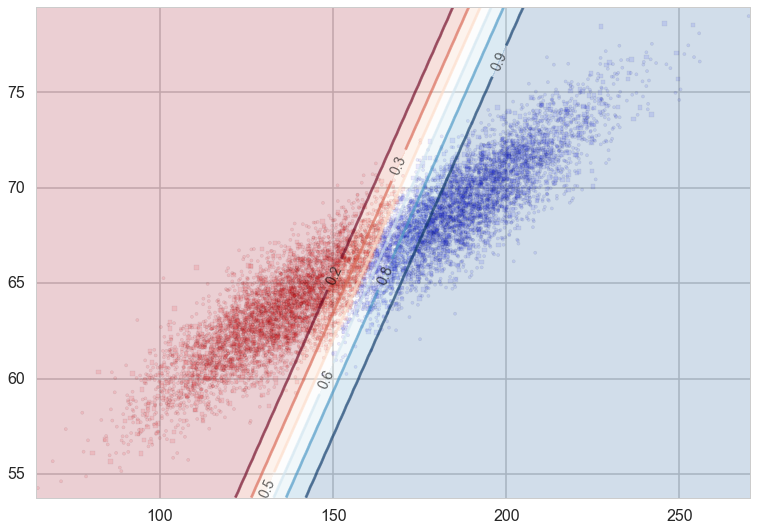

In [15]:
plt.figure()
ax=plt.gca()
points_plot_prob(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clflda);

The important point here is that many generative models, including those with Poisson Likelihoods and Naive Bayes Models have Logistic Regression as their discriminative counterpart. This means that on inverting the $P(\v{x}|y)$ using Bayes theorem, we get back Logistic Regression. Thus Logistic regression if a relatively robust model, insensitive to many modelling assumptions. This is a big reason to use such Discriminative models.

But if $p(\v{x}|y)$ is indeed Normal, as is here for our two classes of male and female, LDA is what is known as **asymptotically efficient**. This means that for large amounts of training data, it can be proved that no model can be better than LDA for the estimation of the probability we'd like to use to get our classification,  $p(y|\v{x})$. In particular, it can be shown that LDA will outperform Logistic regression, even for small training set sizes.

Finally note that there is another major advantage of a generative classifier. We can sum up over class conditional probably density weighted by the priors to estimate the input density from the probability marginalization formula.

$$P(x) = \sum_y P(x|y)P(y)$$

This is not surprising. A lot of elbow-grease went into the generative classifier since we had to model so much. It should pay some dividend.

### Generative vs Discriminative, redux


This is perhaps the right time then to revisit the generative vs discriminative argument, now that we have some experience under our belt.

- If we only wish to make classification decisions rather than more complex decisions then discriminative might be all we need, and it is cheaper in terms of computing resources. But asymmetry and the ability to generate synthetic data are strengths of the generative approach.
- sometimes generative models like LDA and Naive Bayes are easy to fit. The discriminative model LogisticRegression requires convex optimization via Gradient descent
- we can add new classes to a generative classifier without retraining for the previous classes so it might be better for online customer selection problems where customer profiles change
- generative classifiers can handle missing data easily
- generative classifiers are better at handling unlabelled training data (semi-supervized learning)
- preprocessing data is easier with discriminative classifiers
- discriminative classifiers give generally better callibrated probabilities